# Exploratory Data Analysis — Bike Sharing Dataset

**Goal**: Understand patterns in hourly bike rentals (`cnt`) to support building a daily prediction service model for planning processes and bicycle logistics.

Dataset source: [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)


## Table of Contents

- [Load & Preview Data](#1-load-and-preview-data)
- [Basic Cleaning Preprocessing](#2-basic-cleaning--preprocessing)
- [Statistics Analysis](#3-statistics-analysis)
- [Time Series Analysis](#4-time-series-analysis)
- [Model Selection](#5-model-selection)
- [Model Evaluation](#6-model-evaluation)
- [Feature Importance](#7-feature-importance)
- [Bonus Questions](#8-bonus-questions)

In [88]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from utils_nb import *
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from datetime import datetime

In [2]:
def create_and_show_fig(fig, title):
    """Helper function to create and show figures with consistent layout."""
    fig.update_layout(width=600, height=350, title=title)  # Set figure size here
    fig.show()

## 1. Load and Preview Data

In [3]:
df = pd.read_csv("../data/hour.csv")  # 'hour.csv' is the hourly dataset
print(df.shape)
df.head(2)

(17379, 17)


instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40

In [4]:
# data status, columns, dtypes, non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## 2. Basic Cleaning & Preprocessing

### 2.1. Convert 'dteday' to datetime

In [5]:
# Convert date column
df['dteday'] = pd.to_datetime(df['dteday'])

### 2.2. Check  missing values

In [6]:
# Check for missing values
missing_values = df.isnull().values.any()
print(f"Missing values in dataset: {missing_values}")

Missing values in dataset: False


### 2.3 Check Dataset Coverage & Completeness
- A few days contain fewer than 24 records, indicating data incompleteness.

In [7]:
# Check the overall date coverage
print("Date Range:")
print(f"Start: {df['dteday'].min().date()}  |  End: {df['dteday'].max().date()}")

# Count number of unique days
num_days = df['dteday'].nunique()
print(f"Total unique days: {num_days}")

# Show available years
years = df['dteday'].dt.year.unique()
print(f"Years in dataset: {sorted(years)}")

# Check how many records per day (should be 24 ideally)
daily_record_unique_counts = df.groupby('dteday')['instant'].count().value_counts()
print("\nUnique records per day:")
print(daily_record_unique_counts)
print("\n")

# Check duplicates dates and hours
dupli_num = df.duplicated(subset=['dteday', 'hr'], keep='last').shape[0] - df.shape[0]
print(f"Duplicated records number: {dupli_num}")

# Check cnt=0 records
zero_cnt_num = df[df['cnt'] == 0].shape[0]
print(f"Zero cnt records number: {zero_cnt_num}")

Date Range:
Start: 2011-01-01  |  End: 2012-12-31
Total unique days: 731
Years in dataset: [np.int32(2011), np.int32(2012)]

Unique records per day:
instant
24    655
23     62
22      6
18      2
16      1
12      1
8       1
17      1
1       1
11      1
Name: count, dtype: int64


Duplicated records number: 0
Zero cnt records number: 0


In [8]:
# Clean and fill missing hours
df_cleaned = fill_missing_hours(df)

# Confirm daily completeness
assert all(df_cleaned.groupby('dteday')['cnt'].count() == 24)

# Confirm no nulls left
print(df_cleaned.isnull().any().any())

# Preview cleaned data
df_cleaned.head(2)

False


datetime      dteday  hr  cnt  filled  instant  season  yr  mnth  \
0 2011-01-01 00:00:00  2011-01-01   0   16   False        1       1   0     1   
1 2011-01-01 01:00:00  2011-01-01   1   40   False        2       1   0     1   

   holiday  weekday  workingday  weathersit  temp   atemp   hum  windspeed  \
0        0        6           0           1  0.24  0.2879  0.81        0.0   
1        0        6           0           1  0.22  0.2727  0.80        0.0   

   casual  registered  
0       3          13  
1       8          32

## 3. Statistics Analysis

In [9]:
# Target Variable (cnt)
fig_cnt_density = px.histogram(df_cleaned, x='cnt', marginal='rug', title = f'Distribution & Density plot of cnt')
fig_cnt_box = px.box(df_cleaned, y="cnt", title="Box plot of cnt")
create_and_show_fig(fig_cnt_density, 'Distribution & Density plot of cnt')
create_and_show_fig(fig_cnt_box, title="Box plot of cnt")


In [10]:
# Numerical Features
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
for feature in numerical_features:
    fig_box = px.box(df_cleaned, y=feature, title=f"Box plot of {feature}")
    fig_density = px.histogram(df_cleaned, x=feature, marginal='rug', title = f'Distribution & Density plot of {feature}')
    create_and_show_fig(fig_density, f"Distribution & Density plot of {feature}")
    create_and_show_fig(fig_box, f"Box plot of {feature}")

In [11]:
# Categorical Features
# The distribution of ['season', 'yr', 'mnth', 'hr', 'weekday'] is straightforward, ignore here
categorical_features =  ['workingday', 'weathersit']
for feature in categorical_features:
    fig_bar = px.bar(df_cleaned[feature].value_counts().sort_index(), title=f"Count of {feature}")
    create_and_show_fig(fig_bar, f"Count of {feature}")

In [12]:
# 3. Bivariate Analysis
# Target vs. Numerical
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
for feature in numerical_features:
    fig_scatter = px.scatter(df_cleaned, x=feature, y="cnt", title=f"cnt vs. {feature}")
    create_and_show_fig(fig_scatter, f"cnt vs. {feature}")

fig_line_hr = px.line(df_cleaned.groupby('hr')['cnt'].mean().reset_index(), x='hr', y='cnt', title = 'Mean cnt by hour')
create_and_show_fig(fig_line_hr, 'Mean cnt by hour')

In [13]:
# Target vs. Categorical
categorical_features = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'weathersit']
for feature in categorical_features:
    fig_box_cat = px.box(df_cleaned, x=feature, y="cnt", title=f"cnt vs. {feature}")
    create_and_show_fig(fig_box_cat, f"cnt vs. {feature}")
    fig_bar_mean = px.bar(df_cleaned.groupby(feature)['cnt'].mean(), title = f'Mean cnt by {feature}')
    create_and_show_fig(fig_bar_mean, f'Mean cnt by {feature}')

In [14]:
# Correlation Analysis
correlation_matrix = df_cleaned[numerical_features + ['cnt']].corr()
fig_heatmap = px.imshow(correlation_matrix, title="Correlation Matrix")
fig_heatmap.show()

## 4. Time Series Analysis

### 4.1. Count Over Time

In [ ]:
# cnt over time
fig_time_series = px.line(df_cleaned, x='dteday', y='cnt', title='cnt over time')
create_and_show_fig(fig_time_series, "cnt over time")

### 4.2. Daily Count Seasonal Decomposition

In [16]:
df_cleaned['dteday'] = pd.to_datetime(df_cleaned['dteday'])
# Use resample to set the frequency and aggregate to daily sums
daily_cnt = df_cleaned.set_index('dteday')['cnt'].resample('D').sum() #set index, and resample.

# Seasonal Decomposition
decomposition = seasonal_decompose(daily_cnt, model="additive", period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the Decomposition
fig_original = px.line(x=daily_cnt.index, y=daily_cnt, title="Original Time Series")
create_and_show_fig(fig_original, "Original Time Series")

fig_trend = px.line(x=trend.index, y=trend, title="Trend Component")
create_and_show_fig(fig_trend, "Trend Component")

fig_seasonal = px.line(x=seasonal.index, y=seasonal, title="Seasonal Component")
create_and_show_fig(fig_seasonal, "Seasonal Component")

fig_residual = px.line(x=residual.index, y=residual, title="Residual Component")
create_and_show_fig(fig_residual, "Residual Component")

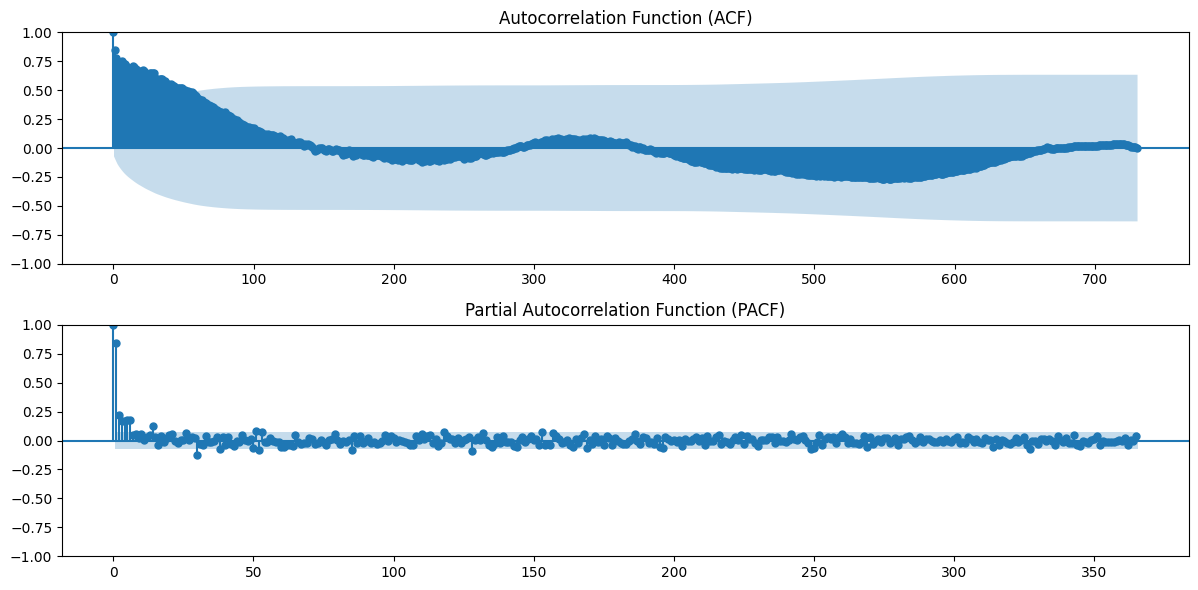

In [19]:
# Daily cnt ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(daily_cnt, lags=730, ax=plt.gca()) #lags set to 365, to show a years worth of data.
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(212)
plot_pacf(daily_cnt, lags=365,ax=plt.gca()) #lags set to 30, to show a month worth of data.
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### 4.3. Hourly Count ACF and PACF

In [20]:
hourly_cnt = df_cleaned.groupby("datetime").cnt.sum()

# Apply Differencing
hourly_diff = hourly_cnt.diff(24).dropna()

check_stationarity(hourly_cnt)
check_stationarity(hourly_diff)

The series is stationary
The series is stationary


In [ ]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(hourly_cnt, lags=24, ax=plt.gca()) #lags set to 365, to show a years worth of data.
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(212)
plot_pacf(hourly_cnt, lags=24,ax=plt.gca()) #lags set to 30, to show a month worth of data.
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
# Plot ACF and PACF using Plotly

plot_acf_pacf_plotly(hourly_cnt, lags=72)

In [ ]:
# Plot ACF and PACF using Plotly

plot_acf_pacf_plotly(hourly_diff, lags=72)


## 5. Model Selection
- Rolling average model (Look back 1 to 7 weeks (same day and hour))
- Arima model, applied 24 hours seasonal differencing and (p, d, q)=(2, 0, 3)
- Xgboost model with lag_24, lag_48, lag_168.
- Test period ("2012-08-01", "2012-08-07") and ("2012-12-25", "2012-12-31")(only for save time, not a fair comparison)

In [21]:
test_weeks = [
    ("2012-08-01", "2012-08-07"),
    ("2012-12-25", "2012-12-31")
]

In [22]:
# Run all models
baseline_df = evaluate_baseline(hourly_cnt, test_weeks)
arima_df = evaluate_arima(hourly_cnt, test_weeks)
xgb_df = evaluate_xgboost_weekly(df_cleaned, test_weeks)


In [23]:
results = pd.concat([arima_df, xgb_df,baseline_df])
results = label_test_period(results, test_weeks)
results['date'] = pd.to_datetime(results['date'])
results = results.sort_values(by=["model", "date"])


In [25]:
# Plotting MAE for each model over the test weeks

# Get the unique test periods
test_periods = results['test_period'].unique()

model_colors = {
    'ARIMA': '#636EFA',
    'Baseline': '#EF553B',
    'XGBoost': '#00CC96'
}

# Create subplots (1 row per test week)
fig = make_subplots(
    rows=len(test_periods),
    cols=1,
    shared_xaxes=False,
    subplot_titles=test_periods
)

for i, period in enumerate(test_periods):
    df_sub = results[results['test_period'] == period]
    models = df_sub['model'].unique()

    for model in models:
        df_model = df_sub[df_sub['model'] == model]
        fig.add_trace(
            go.Scatter(
                x=df_model['date'],
                y=df_model['mae'],
                mode='lines+markers',
                name=model,
                legendgroup=model,
                showlegend=(i == 0),  # only show legend once
                line=dict(color=model_colors.get(model, 'gray'))  # << add this
            ),
            row=i+1,
            col=1
        )

# Update layout
fig.update_layout(
    height=500 * len(test_periods),
    title_text="Model MAE Over Selected Test Weeks (Separate X-Axis)",
    xaxis_title="Date",
    yaxis_title="MAE",
    legend_title="Model"
)

fig.update_xaxes(tickformat="%b %d", tickangle=45)
fig.show()

In [26]:
# Compare mean MAE per model
print(results.groupby('model')['mae'].mean().round(3))

model
ARIMA       59.783
Baseline    79.118
XGBoost     36.896
Name: mae, dtype: float64


## 6. Model Evaluation
<pre>
XGBoost Model Design:
24 individual XGBoost models were trained, one for each hour of the day, to capture hourly specific patterns.
Features included the provided dataset features, as well as engineered features: "lag_1", "rolling_24", "rolling_168", "day_mean", "day_max", "day_min", "day_std", and "day_sum", to incorporate temporal dependencies and daily aggregations.
Data Split
Training Set: Before '2012-07-01'
Validation Set: '2012-07-01' to '2012-10-01'
Test Set: After ‘2012-10-01'
</pre>

In [ ]:
# load the prediction data
# the data is included in the repo, but you can also generate it via python src/predict.py
# or download it from the repo. If is the former, please make sure the date in the filename is correct.
df_eval = pd.read_csv("../data/prediction/test/pred_20250404.csv")

In [45]:
# test date range
df_eval['dteday'] = pd.to_datetime(df_eval['dteday'])
print(df_eval['dteday'].dt.date.min(), df_eval['dteday'].dt.date.max())

2012-10-03 2012-12-31


In [52]:
# daily average mae
daily_maes = {}
for day in df_eval['dteday'].dt.date.unique():
    day_df = df_eval[df_eval['dteday'].dt.date == day]
    cnt_hourly = []
    cnt_hourly_pred = []
    for i in range(1, 25):
        cnt_hourly.append(day_df[f't+{i}'].values[0])
        cnt_hourly_pred.append(day_df[f't+{i}_pred'].values[0])
    cnt_hourly = np.array(cnt_hourly)
    cnt_hourly_pred = np.array(cnt_hourly_pred)
    # Calculate MAE
    mae = mean_absolute_error(cnt_hourly, cnt_hourly_pred)
    daily_maes[day] = mae
# avergage mae
avg_mae = np.mean(list(daily_maes.values()))
print(f"Average MAE: {avg_mae:.2f}")
# plot daily mae
fig_daily_mae = px.line(
    x=list(daily_maes.keys()),
    y=list(daily_maes.values()),
    title="Daily MAE",
    labels={'x': 'Date', 'y': 'MAE'},
    markers=True
)
# Add a horizontal line for the average MAE
fig_daily_mae.add_hline(y=avg_mae, line_dash="dash", line_color="red", annotation_text="Average MAE", annotation_position="top right")
# Update x-axis to show dates properly
fig_daily_mae.update_traces(marker=dict(size=5))
fig_daily_mae.update_xaxes(
    tickformat="%Y-%m-%d",
    tickangle=-45,
    # dtick="W2",  # Show one tick per month
    # tickmode='linear'
)
# Update layout
fig_daily_mae.update_layout(
    title="Daily Mean Absolute Error (MAE)",
    xaxis_title="Date",
    yaxis_title="MAE",
    legend_title_text='Model',
    height=400
)
# Update x-axis to show dates properly
fig_daily_mae.update_traces(marker=dict(size=5))
# fig_daily_mae.update_layout(
#     xaxis_title="Date",
#     yaxis_title="MAE",
#     xaxis_tickangle=-45,
#     xaxis_tickmode='array',
#     xaxis_tickvals=list(daily_maes.keys()),
#     xaxis_ticktext=[str(date) for date in daily_maes.keys()],
#     height=400
# )
fig_daily_mae.show()

Average MAE: 48.11


In [73]:
# daily cnt compared to prediction
daily_cnts = {}
for day in df_eval['dteday'].dt.date.unique():
    day_df = df_eval[df_eval['dteday'].dt.date == day]
    daily_cnt = 0
    daily_cnt_pred = 0
    for i in range(1, 25):
        daily_cnt += day_df[f't+{i}'].values[0]
        daily_cnt_pred += day_df[f't+{i}_pred'].values[0]
    daily_cnts[day] = (daily_cnt, daily_cnt_pred)
# Convert to DataFrame
df_daily_cnts = pd.DataFrame(list(daily_cnts.items()), columns=['date', 'cnt'])
df_daily_cnts[['cnt', 'cnt_pred']] = pd.DataFrame(df_daily_cnts['cnt'].tolist(), index=df_daily_cnts.index)
# Plotting the daily cnt compared to prediction
fig_daily_cnt = px.line(
    df_daily_cnts,
    x='date',
    y=['cnt', 'cnt_pred'],
    title="Daily cnt vs. Daily cnt Prediction",
    labels={'x': 'Date', 'y': 'cnt'},
    markers=True
)
# Update x-axis to show dates properly
fig_daily_cnt.update_traces(marker=dict(size=5))
# Update layout
fig_daily_cnt.update_layout(
    title="Daily cnt vs. Daily cnt Prediction",
    xaxis_title="Date",
    yaxis_title="cnt",
    legend_title_text='Model',
    height=400
)
fig_daily_cnt.show()


## 7. Feature Importance

In [ ]:
# Load 8am(t+9), 12pm(t+13), 5pm(t+18) saved model
# Please note that the model is not saved in the repo, but you can generate it via python src/train.py
# when load the generated model, please make sure the date in the filename is correct.
model = xgb.XGBRegressor()
model.load_model("../models/models_20250402/model_t+18.json")

# Get the booster from the sklearn wrapper
booster = model.get_booster()

# set real feature names if available
# booster.feature_names = ['age', 'income', 'gender', 'education']

# Get feature importance scores (by gain)
importance = booster.get_score(importance_type='gain')

# Convert to DataFrame
df_importance = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by="Importance", ascending=False).head(10)

# Plot with Plotly
fig = px.bar(
    df_importance,
    x="Importance",
    y="Feature",
    orientation='h',
    title="XGBoost Feature Importance 5pm (by Gain)",
    height=400
)
fig.update_layout(yaxis=dict(autorange="reversed"))  # Highest on top
fig.show()

## 8. Bonus Questions

- **Q1:** Which intervals would you suggest to refresh the forecasts during operations? Why?  
  To optimize bicycle rental operations, I suggest a tiered forecast refresh strategy:

  - **Daily Hourly Updates:** Crucial for immediate logistics, capturing daily weather fluctuations (most reliable within 1–3 day weather forecast range).
  - **Weekly Aggregated Refreshes:** For mid-term planning (staffing, maintenance), balancing trends with decreasing weather forecast accuracy.
  - **Event-Driven Refreshes:** Triggered by significant weather changes, events, or data anomalies, ensuring rapid operational adjustments.
  - **Monthly/Quarterly Scenario Outlooks:** For long-term strategic planning, providing general trends while acknowledging the inherent uncertainty of long-range weather forecasts.

  This strategy prioritizes short-term accuracy for operational efficiency and uses long-term outlooks for strategic guidance, with clear consideration for weather forecast reliability.

- **Q2:** How far out into the future is your model good for planning? Why?  
  With a simple ARIMA prediction, the difference between the prediction termination day and the start day is approximately **3 months (86 days)**.



The series is stationary


/Users/wenjuanyang/conda/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/wenjuanyang/conda/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/wenjuanyang/conda/anaconda3/envs/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/var/folders/sw/nq9chr0j4zz71g7by54zg9pc0000gn/T/ipykernel_14722/231662041.py:27: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/sw/nq9chr0j4zz71g7by54zg9pc0000gn/T/ipykernel_1472

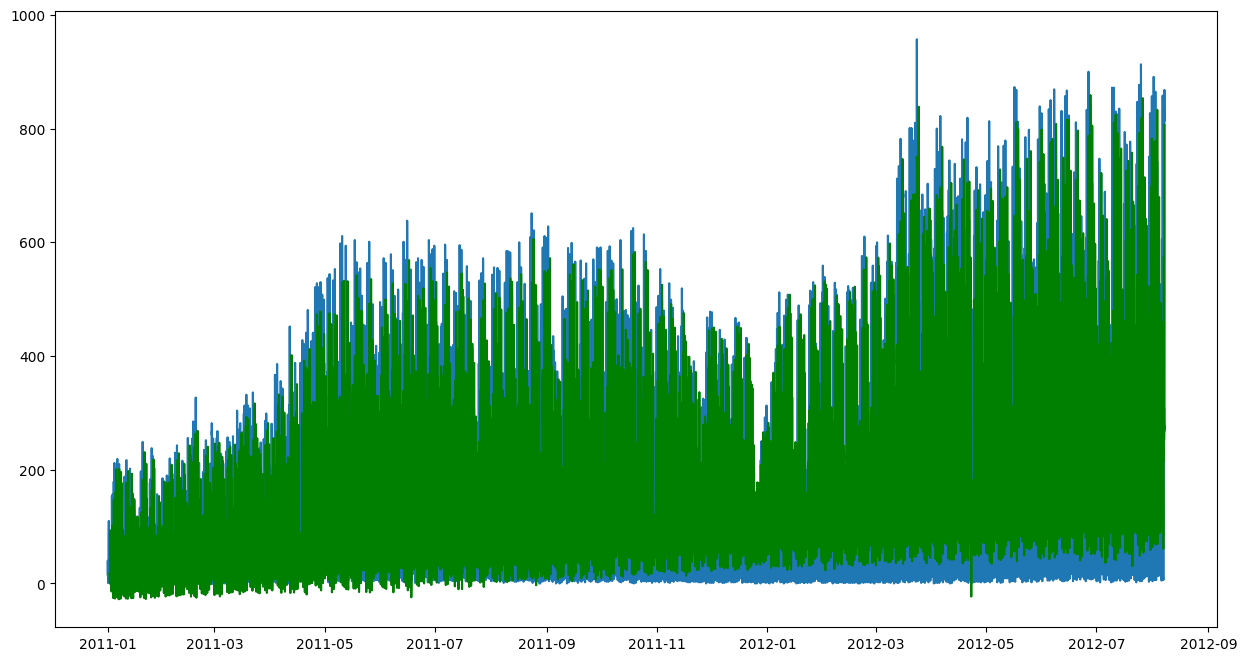

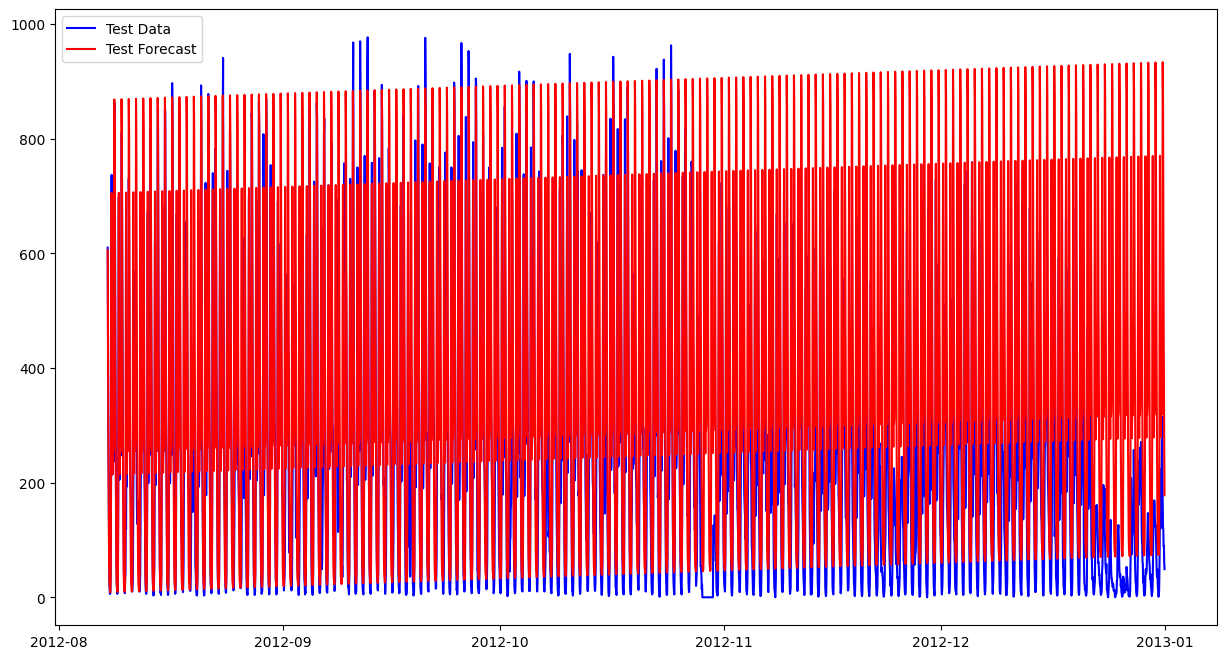

Train mae: 77.24254400138723
Test mae: 133.2800343019864


In [76]:
# 2. Split to Train and Test
train_size = int(len(hourly_cnt) * 0.8)
train, test = hourly_cnt[:train_size], hourly_cnt[train_size:]

# 3. Apply Seasonal Differencing
seasonal_lag = 24
train_diff = train.diff(seasonal_lag).dropna()
check_stationarity(train_diff)

# 4. Fit SARIMA Model (Example)
model = ARIMA(train_diff, order=(2, 0, 3))
results = model.fit()

# 5. Forecast Train and Test
train_forecast_diff = results.fittedvalues
test_forecast_diff = results.forecast(steps=len(test))

# 6. Inverse Transformation for Train
train_forecast_original = pd.Series(index=train_diff.index)

# Initialize the first 24 values
for i in range(seasonal_lag):
    train_forecast_original[train_diff.index[i]] = train[train_diff.index[i]]

# Inverse transform the rest of the values
for i in range(seasonal_lag, len(train_diff)):
    train_forecast_original[train_diff.index[i]] = train_forecast_original[train_diff.index[i - seasonal_lag]] + train_forecast_diff[i-seasonal_lag]

# 7. Inverse Transformation for Test
test_forecast_original = pd.Series(index=test.index)

# Initialize the first 24 values using the last 24 values from train
for i in range(seasonal_lag):
    test_forecast_original[test.index[i]] = train[-seasonal_lag + i] + test_forecast_diff[i]

# Inverse transform the rest of the values
for i in range(seasonal_lag, len(test_forecast_diff)):
    test_forecast_original[test.index[i]] = test_forecast_original[test.index[i - seasonal_lag]] + test_forecast_diff[i]

# 8. Plot Train and Test Predictions
plt.figure(figsize=(15, 8))
plt.plot(train, label='Train Data')
plt.plot(train_forecast_original, label='Train Forecast', color='green')
plt.show()
plt.figure(figsize=(15, 8))

plt.plot(test, label='Test Data', color='blue')
plt.plot(test_forecast_original, label='Test Forecast', color='red')
plt.legend()
plt.show()
mae_train = mean_absolute_error(train[24:], train_forecast_original)
mae_test = mean_absolute_error(test, test_forecast_original)
print(f"Train mae: {mae_train}")
print(f"Test mae: {mae_test}")

In [84]:
# plot test and forecast devation
test_daily = test.resample('D').sum()
test_forecast_original_daily = test_forecast_original.resample('D').sum()

# Calculate absolute deviation
deviation = (test_daily - test_forecast_original_daily).abs()

# Create the Plotly figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = test_daily.index,
    y=deviation,
    mode='lines',
    name='Test Data actual vs pred deviation',
    line=dict(color='blue')
))

fig.update_layout(
    title='Test Data actual vs pred deviation',
    xaxis_title='Date',
    yaxis_title='Absolute Deviation',
    width=600,
    height=400
)

fig.show()

In [ ]:
date1 = datetime(2012, 11, 1)
date2 = datetime(2012, 8, 7)

# Calculate the difference
day_difference = (date1 - date2).days

print(f"Day difference: {day_difference} days")

Day difference: 86 days
